# A/B-тест (приложение доставки)

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:  

**ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи  
**ab_orders** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ  
**ab_products** – подробная информация о продуктах, их название и стоимость

# 1.Предварительный анализ данных

In [1]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sns
import scipy.stats as ss
import scipy
import numpy as np
from scipy.stats import bootstrap

## 1.1 Проанализируем таблицу users_data

In [2]:
users_data = pd.read_csv('ab_users_data.csv')
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [3]:
users_data.shape

(4337, 6)

In [4]:
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [5]:
users_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [6]:
# Приведем формат столбцов с датой и временем в формат datetime

users_data[['time', 'date']] = users_data[['time', 'date']].apply(pd.to_datetime)     

In [7]:
users_data.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [8]:
# Посмотрим период времени, за который есть данные. Данные представлены за 2 недели: с 26.08.2022 по 08.09.2022

users_data.time.min()

Timestamp('2022-08-26 00:00:19')

In [9]:
users_data.time.max()

Timestamp('2022-09-08 23:41:24')

In [10]:
# Посмотрим кол-во уникальных заказов

users_data.order_id.nunique()

4123

In [11]:
# Посмотрим, какие есть статусы заказа. Есть только 2 статуса: создание или отмена заказа

users_data.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [12]:
# Посмотрим, как представлена информация об отмененных заказах, т.е. ли по ним строки и create_order, и cancel_order.
# Отберем заказы, у которых больше 1 статуса заказа в таблице. Их 214 (как и кол-во отмененных заказов).
# То есть по отмененным заказам есть сразу 2 статуса: create_order и cancel_order.

users_data.groupby('order_id')\
           .agg({'action' : 'count'}) \
           .query('action > 1') \
           .sort_values('action', ascending = False)

,action
order_id,
1258,2
16735,2
17506,2
17615,2
18427,2
...,...
3659,2
3699,2
4057,2


In [13]:
# Посмотрим, есть ли пользователи, которые сделали несколько заказов. Такие пользователи есть.

users_data.user_id.value_counts()

1533    16
1641    15
1170    13
1685    12
1382    12
        ..
1430     1
1548     1
1332     1
1679     1
1327     1
Name: user_id, Length: 1017, dtype: int64

In [14]:
# Посмотрим, сколько пользователей в 2 группах

number_users = users_data.groupby('group', as_index = False) \
                         .agg({'user_id' : 'nunique'}) \
                         .rename(columns = {'user_id' : 'users'})
number_users

,group,users
0,0,515
1,1,502


In [15]:
# Посмотрим, сколько заказов в 2 группах

number_total_orders = users_data.groupby('group', as_index = False) \
                           .agg({'order_id' : 'nunique'}) \
                           .rename(columns = {'order_id' : 'total_orders'})
number_total_orders 

,group,total_orders
0,0,1609
1,1,2514


In [16]:
# Посмотрим, сколько отмененных заказов в 2 группах

number_cancel_orders = users_data.query('action == "cancel_order"') \
                                .groupby('group', as_index = False) \
                                .agg({'order_id' : 'nunique'}) \
                                .rename(columns = {'order_id' : 'cancel_orders'})
number_cancel_orders

,group,cancel_orders
0,0,82
1,1,132


In [17]:
# Объединим таблицы и посчитаем число совершенных (= неотмененных) заказов

number_orders = number_total_orders.merge(number_cancel_orders, on = 'group')
number_orders['completed_orders'] = number_orders.total_orders - number_orders.cancel_orders
number_orders

,group,total_orders,cancel_orders,completed_orders
0,0,1609,82,1527
1,1,2514,132,2382


## 1.2 Проанализируем таблицу orders

In [18]:
orders = pd.read_csv('ab_orders.csv')
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [19]:
orders.shape

(4123, 3)

In [20]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [21]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [22]:
# Приведем формат столбцов с датой и временем в формат datetime

orders['creation_time'] = pd.to_datetime(orders.creation_time)

In [23]:
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

In [24]:
# Переведем столбец product_ids в формат списка, убрав лишние символы

orders['product_ids'] = orders.product_ids.str.strip('{').str.strip('}').str.split(', ')
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [25]:
# Переформатируем таблицу, выделив каждый элемент в столбце product_ids в отдельную строку

orders = orders.explode('product_ids')
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


In [26]:
# Переименуем product_ids в product_id для сопоставления названия столбцов в таблицах orders и products и установим для 
# столбца product_id тип данных int

orders = orders.rename(columns = {'product_ids' : 'product_id'})
orders['product_id'] = orders.product_id.astype('int')
orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


In [27]:
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_id                int64
dtype: object

In [28]:
# Посмотрим кол-во уникальных заказов. Их 4123 (столько же, сколько в таблице users_data)

orders.order_id.nunique()

4123

In [29]:
# Период времени,за который представлены данные, совпадает с таблицей users_data

orders.creation_time.min()

Timestamp('2022-08-26 00:00:19')

In [30]:
orders.creation_time.max()

Timestamp('2022-09-08 23:41:24')

In [31]:
# Посмотрим, как формируется столбец product_id.
# Мы видим, что в одном заказе может быть несколько одинаковых product_id, т.е. если покупатель купил несколько одинаковых
# товаров, в таблице это будет записано как несколько строк с одинаковым product_id (т.е. нет столбца "кол-во товаров")

orders.groupby(['order_id', 'product_id'], as_index = False) \
      .agg({'creation_time' : 'count'}) \
      .rename(columns = {'creation_time' : 'number_products'}) \
      .sort_values('number_products', ascending = False)

,order_id,product_id,number_products
6682,9402,6,3
3503,2491,57,3
10221,27275,35,3
6775,9615,34,2
737,1529,3,2
...,...,...,...
4558,3370,5,1
4559,3370,28,1
4560,3370,31,1
4561,3370,56,1


In [32]:
# для примера посмотрим на заказ 9402. Наша логика подтверждается

orders.query('order_id == 9402')

,order_id,creation_time,product_id
2032,9402,2022-08-29 11:26:32,63
2032,9402,2022-08-29 11:26:32,21
2032,9402,2022-08-29 11:26:32,6
2032,9402,2022-08-29 11:26:32,6
2032,9402,2022-08-29 11:26:32,6


## 1.3 Проанализируем таблицу products

In [33]:
products = pd.read_csv('ab_products.csv')
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [34]:
products.shape

(87, 3)

In [35]:
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [36]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [37]:
# Кол-во уникальных значений в product_id совпадает с кол-вом строк в таблице, т.е. по каждому product_id есть только 1 строка

products.product_id.nunique()

87

# 2. Выбор и расчет метрик

1. Эффективная система рекомендаций влияет на кол-во заказов, сделанных пользователями. При этом у нас есть отмененные заказы, которые не влияют на денежные потоки компании. Поэтому в метриках мы будем учитывать только совершенные ( = неотмененные) заказы.
2. Можно оценивать как кол-во заказов, так и сумму денег, которые эти заказы принесли, а также среднюю сумму 1 заказа.

**Итого для того, чтобы проанализировать результаты теста с разных сторон (и потренироваться в учебных целях), мы будем рассчитывать 3 метрики**:  

**1. Среднее кол-во совершенных заказов (на 1 человека)**  
**2. Средняя сумма совершенных заказов (на 1 человека)**  
**3. Средний чек (1 заказа)**

## 2.1 Создание сводной таблицы для расчета метрик для группы 0 и группы 1

In [38]:
# Отберем order_id совершенных (=неотмененных) заказов. Для этого сгруппируем таблицу users_data по order_id, посчитаем кол-во
# action по каждому заказу и отберем заказы только с 1 action (так как у отмененных заказов будет 2 action: create и cancel)

completed_orders = users_data.groupby('order_id', as_index = False)\
                           .agg({'action' : 'count'}) \
                           .query('action == 1') 
completed_orders

,order_id,action
0,1255,1
1,1256,1
2,1257,1
4,1259,1
5,1261,1
...,...,...
4118,59422,1
4119,59439,1
4120,59464,1
4121,59487,1


In [39]:
# Создадим список из совершенных заказов 

completed_orders_list = completed_orders.order_id.to_list()

In [40]:
# Отберем из всех заказов в таблице orders только совершенные (=неотмененные заказы), и объединим их с ценами по каждому 
# продукту из таблицы products, а также удалим ненужные столбцы

completed_orders_price = orders.query('order_id == @completed_orders_list') \
                         .merge(products[['product_id', 'price']], on = 'product_id', how = 'inner') \
                         .drop(columns = 'creation_time')

completed_orders_price.head()

,order_id,product_id,price
0,1255,75,120.0
1,1287,75,120.0
2,1403,75,120.0
3,1424,75,120.0
4,1495,75,120.0


In [41]:
# Сгруппируем таблицу по order_id и найдем сумму каждого заказа

completed_orders_price = completed_orders_price.groupby('order_id', as_index = False) \
                                                .agg({'price' : 'sum'})
completed_orders_price.head()

,order_id,price
0,1255,408.7
1,1256,250.5
2,1257,310.2
3,1259,228.0
4,1261,430.7


In [42]:
# Добавим к каждому order_id следующие столбцы из таблицы users_data: user_id, group

completed_orders_price = completed_orders_price.merge(users_data[['user_id', 'order_id', 'group']], on = 'order_id', how = 'inner')
completed_orders_price.head()

,order_id,price,user_id,group
0,1255,408.7,964,0
1,1256,250.5,965,1
2,1257,310.2,964,0
3,1259,228.0,967,1
4,1261,430.7,968,0


In [43]:
# Отберем только совершенные заказы, которые входят в группу 0. Сгруппируем по user_id и для каждого пользователя посчитаем
# кол-во сделанных им заказов и их сумму. Сводная таблица для группы 0 готова

completed_orders_price_group_0 = completed_orders_price.query('group == 0') \
                                                      .groupby('user_id', as_index = False) \
                                                      .agg({'order_id' : 'count', 'price' : 'sum'}) \
                                                      .rename(columns = {'order_id' : 'orders'})
completed_orders_price_group_0.head()

,user_id,orders,price
0,964,2,718.9
1,968,3,1590.7
2,969,2,681.9
3,972,1,546.4
4,975,2,1432.9


In [44]:
# Отберем только совершенные заказы, которые входят в группу 1. Сгруппируем по user_id и для каждого пользователя посчитаем
# кол-во сделанных им заказов и их сумму. Сводная таблица для группы 1 готова

completed_orders_price_group_1 = completed_orders_price.query('group == 1') \
                                                      .groupby('user_id', as_index = False) \
                                                      .agg({'order_id' : 'count', 'price' : 'sum'}) \
                                                      .rename(columns = {'order_id' : 'orders'})
completed_orders_price_group_1.head()

,user_id,orders,price
0,965,9,4155.5
1,967,5,1137.4
2,970,2,802.8
3,971,5,1968.4
4,973,3,1285.8


## 2.2 Расчет метрики "Среднее кол-во совершенных заказов на 1 человека"
## 2.2.1 Проверка нормальности распределения данных

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


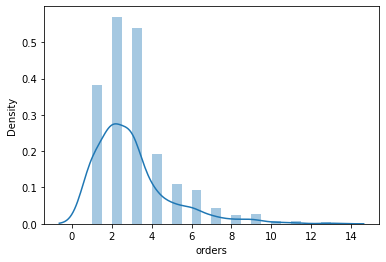

In [45]:
# Посмотрим на распределение кол-ва заказов в группе 0

sns.distplot(completed_orders_price_group_0.orders)

In [46]:
# Проверим нормальность данных в группе 0 с помощью теста Агостино-Пирсона

scipy.stats.normaltest(completed_orders_price_group_0.orders)

NormaltestResult(statistic=178.2666269087672, pvalue=1.949367912093664e-39)

In [47]:
if scipy.stats.normaltest(completed_orders_price_group_0.orders)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**Вывод:p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе 0 распределены ненормально**

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


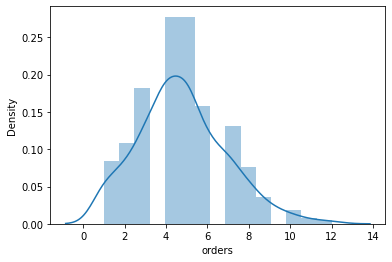

In [48]:
# Посмотрим на распределение кол-ва заказов в группе 1

sns.distplot(completed_orders_price_group_1.orders)

In [49]:
# Проверим нормальность данных в группе 1 с помощью теста Агостино-Пирсона

scipy.stats.normaltest(completed_orders_price_group_1.orders)

NormaltestResult(statistic=17.210719490871693, pvalue=0.0001831216731538631)

In [50]:
if scipy.stats.normaltest(completed_orders_price_group_1.orders)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**Вывод: p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе 1 распределены ненормально** 

## 2.2.2 Статистический тест
Распределение признака отличается от нормального, поэтому будем использовать непараметрический аналог t-теста – U-критерий Манна-Уитни. 

In [51]:
scipy.stats.mannwhitneyu(completed_orders_price_group_0.orders, completed_orders_price_group_1.orders)

MannwhitneyuResult(statistic=62993.5, pvalue=1.2199751971495041e-45)

In [52]:
if scipy.stats.mannwhitneyu(completed_orders_price_group_0.orders, completed_orders_price_group_1.orders)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**P-value < 0.05, отклоняем Ho об отсутствии различий, различия между группами признаются статистически значимыми.**

Дополнительно проведем bootstrap и оценим 95% доверительный интервал для средних в 2 группах

In [53]:
bootstrap((completed_orders_price_group_0.orders, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=2.82421875, high=3.150390625), standard_error=0.08310501833366127)

In [54]:
bootstrap((completed_orders_price_group_1.orders, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=4.56686626746507, high=4.940119760479042), standard_error=0.09576637645245092)

**Доверительные интервалы средних группы 0 и 1 не пересекаются, из чего можно сделать вывод, что получено статистически значимое различие между средними двух групп.**

## 2.2.3 Сравнение средних в 2 группах

In [55]:
# Теперь считаем и сравниваем среднее кол-во совершенных заказов на человека в 2 группах

mean_orders_group_0 = completed_orders_price_group_0.orders.mean()
mean_orders_group_0

2.982421875

In [56]:
mean_orders_group_1 = completed_orders_price_group_1.orders.mean()
mean_orders_group_1

4.754491017964072

## 2.2.4 Вывод
**Среднее кол-во совершенных заказов на 1 человека в группе 1 статистически значимо больше, чем в группе 0. Соответственно, исходя из данной метрики, можем сделать вывод, что новая система рекомендаций эффективнее, чем старая, и ее следует распространить на всех пользователей**

## 2.3 Расчет метрики "Средняя сумма совершенных заказов на 1 человека"
## 2.3.1 Проверка нормальности распределения данных

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


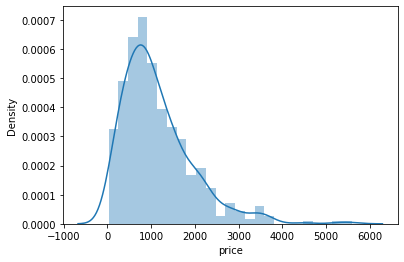

In [57]:
# Посмотрим на распределение суммы заказов в группе 0

sns.distplot(completed_orders_price_group_0.price)

In [58]:
# Проверим нормальность данных в группе 0 с помощью теста Агостино-Пирсона

scipy.stats.normaltest(completed_orders_price_group_0.price)

NormaltestResult(statistic=165.14145937540576, pvalue=1.3803452652449819e-36)

In [59]:
if scipy.stats.normaltest(completed_orders_price_group_0.price)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**Вывод: p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе 0 распределены ненормально** 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


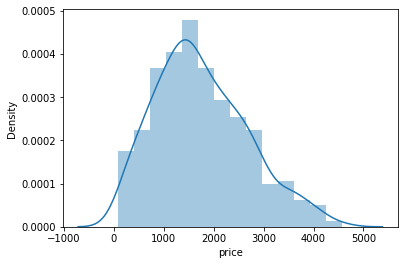

In [60]:
# Посмотрим на распределение суммы заказов в группе 1

sns.distplot(completed_orders_price_group_1.price)

In [61]:
# Проверим нормальность данных в группе 1 с помощью теста Агостино-Пирсона

scipy.stats.normaltest(completed_orders_price_group_1.price)

NormaltestResult(statistic=21.24303377815477, pvalue=2.438562133100666e-05)

In [62]:
if scipy.stats.normaltest(completed_orders_price_group_1.price)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**Вывод: p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе 1 распределены ненормально** 

## 2.3.2 Статистический тест
Распределение признака отличается от нормального, поэтому будем использовать непараметрический аналог t-теста – U-критерий Манна-Уитни. 

In [63]:
scipy.stats.mannwhitneyu(completed_orders_price_group_0.price, completed_orders_price_group_1.price)

MannwhitneyuResult(statistic=75129.0, pvalue=3.678772647034779e-30)

In [64]:
if scipy.stats.mannwhitneyu(completed_orders_price_group_0.price, completed_orders_price_group_1.price)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**P-value < 0.05, отклоняем Ho об отсутствии различий, различия между группами признаются статистически значимыми.**

Дополнительно проведем bootstrap и оценим 95% доверительный интервал для средних в 2 группах

In [65]:
bootstrap((completed_orders_price_group_0.price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1072.989503494906, high=1215.0806608914531), standard_error=36.174753955539416)

In [66]:
bootstrap((completed_orders_price_group_1.price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1672.8512988846412, high=1834.542903671902), standard_error=41.35869661693274)

**Доверительные интервалы средних группы 0 и 1 не пересекаются, из чего можно сделать вывод, что получено статистически значимое различие между средними двух групп.**

## 2.3.3 Сравнение средних в 2 группах

In [67]:
# Теперь считаем и сравниваем среднюю сумму совершенных заказов на человека в 2 группах

mean_price_group_0 = completed_orders_price_group_0.price.mean()
mean_price_group_0

1139.5623046875

In [68]:
mean_price_group_1 = completed_orders_price_group_1.price.mean()
mean_price_group_1

1753.7493013972055

## 2.3.4 Вывод
**Средняя сумма заказов на 1 человека в группе 1 статистически значимо больше, чем в группе 0. Соответственно, исходя из данной метрики, можем сделать вывод, что новая система рекомендаций эффективнее, чем старая, и ее следует распространить на всех пользователей**

## 2.4 Расчет метрики "Средний чек"

In [69]:
# Отберем совершенные заказы и их сумму из группы 0

avg_price_group_0 = completed_orders_price.query('group == 0')[['order_id', 'price']]
avg_price_group_0.head()

,order_id,price
0,1255,408.7
2,1257,310.2
4,1261,430.7
5,1262,358.6
8,1265,546.4


In [70]:
# Отберем совершенные заказы и их сумму из группы 1

avg_price_group_1 = completed_orders_price.query('group == 1')[['order_id', 'price']]
avg_price_group_1.head()

,order_id,price
1,1256,250.5
3,1259,228.0
6,1263,180.3
7,1264,310.3
9,1266,46.0


## 2.4.1 Проверка нормальности распределения данных

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


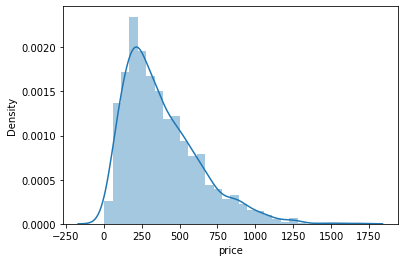

In [71]:
# Посмотрим на распределение суммы среднего чека в группе 0

sns.distplot(avg_price_group_0.price)

In [72]:
# Проверим нормальность данных в группе 0 с помощью теста Агостино-Пирсона

scipy.stats.normaltest(avg_price_group_0.price)

NormaltestResult(statistic=276.0397772146938, pvalue=1.1447851440676955e-60)

In [73]:
if scipy.stats.normaltest(avg_price_group_0.price)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**Вывод: p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе 0 распределены ненормально** 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


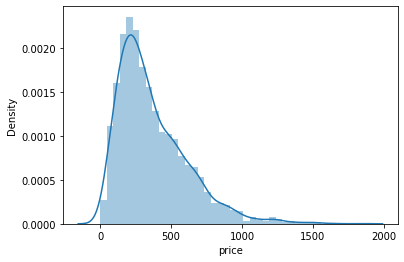

In [74]:
# Посмотрим на распределение суммы среднего чека в группе 1

sns.distplot(avg_price_group_1.price)

In [75]:
# Проверим нормальность данных в группе 1 с помощью теста Агостино-Пирсона

scipy.stats.normaltest(avg_price_group_1.price)

NormaltestResult(statistic=586.947837865446, pvalue=3.5147660678462184e-128)

In [76]:
if scipy.stats.normaltest(avg_price_group_1.price)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


**Вывод: p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе 1 распределены ненормально** 

## 2.4.2 Статистический тест
Распределение признака отличается от нормального, поэтому будем использовать непараметрический аналог t-теста – U-критерий Манна-Уитни. 

In [77]:
scipy.stats.mannwhitneyu(avg_price_group_0.price, avg_price_group_1.price)

MannwhitneyuResult(statistic=1879866.0, pvalue=0.07540906614048998)

In [78]:
if scipy.stats.mannwhitneyu(avg_price_group_0.price, avg_price_group_1.price)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем H1


**P-value > 0.05, мы не можем отклонить Ho об отсутствии различий, различия между группами по данному показателю признаются статистически незначимыми.**

Дополнительно проведем bootstrap и оценим 95% доверительный интервал для средних в 2 группах

In [79]:
bootstrap((avg_price_group_0.price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=370.08987653329723, high=394.91186772031193), standard_error=6.309926667496564)

In [80]:
bootstrap((avg_price_group_1.price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=358.9570730150886, high=378.78348212466653), standard_error=5.06866304634566)

**Доверительные интервалы средних группы 0 и 1 пересекаются, из чего можно сделать вывод, что различие между средними двух групп статистически незначимо.**

## 2.4.3 Сравнение средних в 2 группах

In [81]:
avg_price_group_0.price.mean()

382.09292730844794

In [82]:
avg_price_group_1.price.mean()

368.86162888329136

## 2.4.4 Вывод
**Различия между 2 группами по среднему чеку нельзя признать статистически значимыми. То есть, несмотря на то, что средний чек в группе 1 ниже, чем в группе 0 (т.е. мы получили обратные результаты по сравнению с другими метриками), по показателю среднего чека сделать вывод об эффективности системы рекомендации нельзя.**

# 3. Общий вывод

1.Для анализа эффективности новой системы рекомендаций были рассчитаны 3 метрики в 2 группах: в группе 0 (старая система рекомендаций) и в группе 1 (новая система рекомендаций):  
- Среднее кол-во совершенных заказов (на 1 человека) 
- Средняя сумма совершенных заказов (на 1 человека)
- Средний чек (1 заказа)

2.По метрике "Средний чек" нельзя сделать вывод об эффективности системы рекомендаций, так как различия между группами по данной метрике оказались статистически незначимыми.

3.Остальные две метрики статистически значимо выше в группе 1 по сравнению с группой 0.  

4.Из этого можно сделать вывод, что новая система рекомендаций эффективнее, чем старая, и ее следует распространить на всех пользователей